# 44 Classes

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.model_selection import train_test_split
import os

In [9]:
# Set the path to the dataset
data_dir = '../models/data/'

# Create a list of file paths and corresponding labels
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    if not os.path.isdir(foldpath):
        continue
    
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Create a DataFrame
Fseries = pd.Series(filepaths, name='path')
Lseries = pd.Series(labels, name='class')
df = pd.concat([Fseries, Lseries], axis=1)

In [5]:
# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
train_df, valid_df = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=123)

# Create an ImageDataGenerator for the training set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a separate ImageDataGenerator for validation and test sets (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255.)

# Create data generators
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='class',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

valid_gen = val_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='class',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='class',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2865 validated image filenames belonging to 44 classes.
Found 717 validated image filenames belonging to 44 classes.


c:\Users\calviem\OneDrive - Rose-Hulman Institute of Technology\Desktop\brain_scan_analyzer\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 896 validated image filenames belonging to 44 classes.


In [7]:
# Model Architecture (remains the same)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(44, activation='softmax')
])

c:\Users\calviem\OneDrive - Rose-Hulman Institute of Technology\Desktop\brain_scan_analyzer\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Model Compilation (remains the same)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks (remains the same)
model_filepath = 'best_model.keras'
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True, verbose=1)

In [11]:
# Model Training (remains the same)
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100, # With augmentation, you might be able to train for more epochs without overfitting
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluation (remains the same)
loss, accuracy = model.evaluate(test_gen)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0566 - loss: 3.7238
Epoch 1: val_loss improved from inf to 3.38338, saving model to best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.0568 - loss: 3.7226 - val_accuracy: 0.1046 - val_loss: 3.3834
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1224 - loss: 3.4299
Epoch 2: val_loss improved from 3.38338 to 3.19336, saving model to best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.1223 - loss: 3.4296 - val_accuracy: 0.1492 - val_loss: 3.1934
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1381 - loss: 3.2865
Epoch 3: val_loss improved from 3.19336 to 2.80700, saving model to best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1384 - loss: 3.2856 - val_accuracy: 0.2357 - val_loss: 2.8070
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.2112 - loss: 2.9982
Epoch 4: val_loss improved from 2.80700 to 2.53847, saving mode

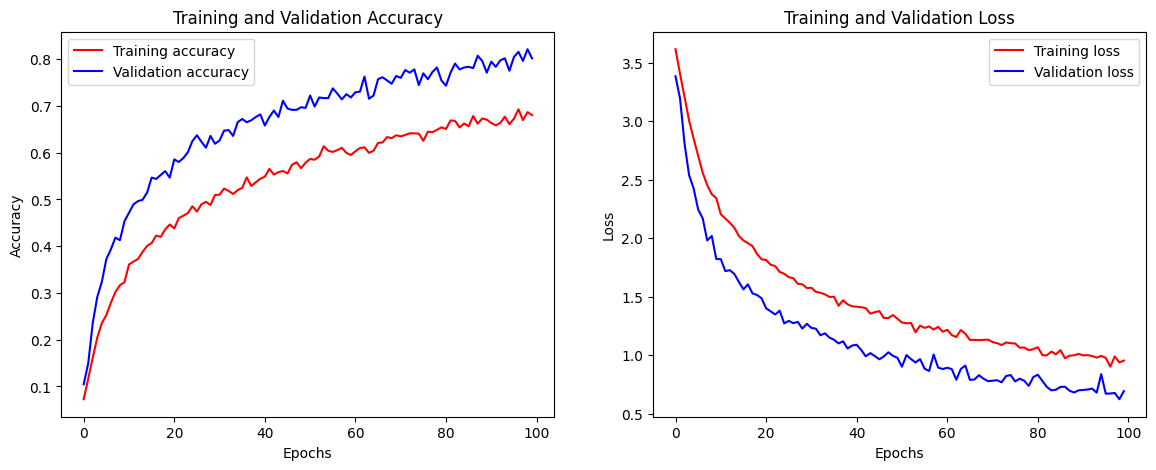

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# -----------------------------------------------------------
# 8. Visualize Training History and Show Example Predictions
# -----------------------------------------------------------

# Plotting Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 15 classes

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.model_selection import train_test_split
import os

In [12]:
# Set the path to the dataset
data_dir = '../models/data/'

# --- MODIFIED SECTION: Create a list of file paths and consolidated labels ---
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    if not os.path.isdir(foldpath):
        continue
    
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        
        # Consolidate the label by taking the first part of the folder name
        # e.g., 'Astrocitoma T1C+' becomes 'Astrocitoma'
        # e.g., '_NORMAL T1' becomes '_NORMAL'
        consolidated_label = fold.split(' ')[0]
        labels.append(consolidated_label)

# Create a DataFrame
Fseries = pd.Series(filepaths, name='path')
Lseries = pd.Series(labels, name='class')
df = pd.concat([Fseries, Lseries], axis=1)

# Verify the number of classes is now 15
print(f"Number of unique classes after consolidation: {len(df['class'].unique())}")
print(df['class'].unique())

Number of unique classes after consolidation: 15
['Astrocitoma' 'Carcinoma' 'Ependimoma' 'Ganglioglioma' 'Germinoma'
 'Glioblastoma' 'Granuloma' 'Meduloblastoma' 'Meningioma' 'Neurocitoma'
 'Oligodendroglioma' 'Papiloma' 'Schwannoma' 'Tuberculoma' '_NORMAL']


In [13]:
# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
train_df, valid_df = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=123)


# Create an ImageDataGenerator for the training set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a separate ImageDataGenerator for validation and test sets (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255.)

# Create data generators
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='class',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

valid_gen = val_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='class',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='class',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2865 validated image filenames belonging to 15 classes.


c:\Users\calviem\OneDrive - Rose-Hulman Institute of Technology\Desktop\brain_scan_analyzer\venv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 717 validated image filenames belonging to 15 classes.
Found 896 validated image filenames belonging to 15 classes.


In [16]:
# --- MODIFIED SECTION: Model Architecture ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    # Change the final layer to have 15 output neurons
    Dense(15, activation='softmax')
])

# Model Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
model_filepath = 'best_model_15_classes.keras'
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True, verbose=1)

# Model Training
history15 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluation
loss, accuracy = model.evaluate(test_gen)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

c:\Users\calviem\OneDrive - Rose-Hulman Institute of Technology\Desktop\brain_scan_analyzer\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\calviem\OneDrive - Rose-Hulman Institute of Technology\Desktop\brain_scan_analyzer\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.1594 - loss: 2.7741
Epoch 1: val_loss improved from inf to 2.26729, saving model to best_model_15_classes.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.1597 - loss: 2.7716 - val_accuracy: 0.2636 - val_loss: 2.2673
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.2421 - loss: 2.3586
Epoch 2: val_loss improved from 2.26729 to 2.08943, saving model to best_model_15_classes.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 83s 917ms/step - accuracy: 0.2422 - loss: 2.3582 - val_accuracy: 0.3361 - val_loss: 2.0894
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.2807 - loss: 2.1968
Epoch 3: val_loss improved from 2.08943 to 1.95560, saving model to best_model_15_classes.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 826ms/step - accuracy: 0.2807 - loss: 2.1968 - val_accuracy: 0.3738 - val_loss: 1.9556
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.3052 - loss: 2.1298
Epoch 4: val_loss

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# -----------------------------------------------------------
# 8. Visualize Training History and Show Example Predictions
# -----------------------------------------------------------

# Plotting Accuracy and Loss
acc = history15.history['accuracy']
val_acc = history15.history['val_accuracy']
loss = history15.history['loss']
val_loss = history15.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

NameError: name 'history15' is not defined

In [1]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history15.history['accuracy']
val_acc = history15.history['val_accuracy']
loss = history15.history['loss']
val_loss = history15.history['val_loss']
epochs = range(len(acc))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy on primary y-axis
ax1.plot(epochs, acc, 'r-', label='Training Accuracy')
ax1.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create a secondary y-axis for loss
ax2 = ax1.twinx()
ax2.plot(epochs, loss, 'b-', label='Training Loss')
ax2.plot(epochs, val_loss, 'b--', label='Validation Loss')
ax2.set_ylabel('Loss', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', ncol=2)

plt.title('Training and Validation Accuracy & Loss')
plt.tight_layout()
plt.show()


NameError: name 'history15' is not defined

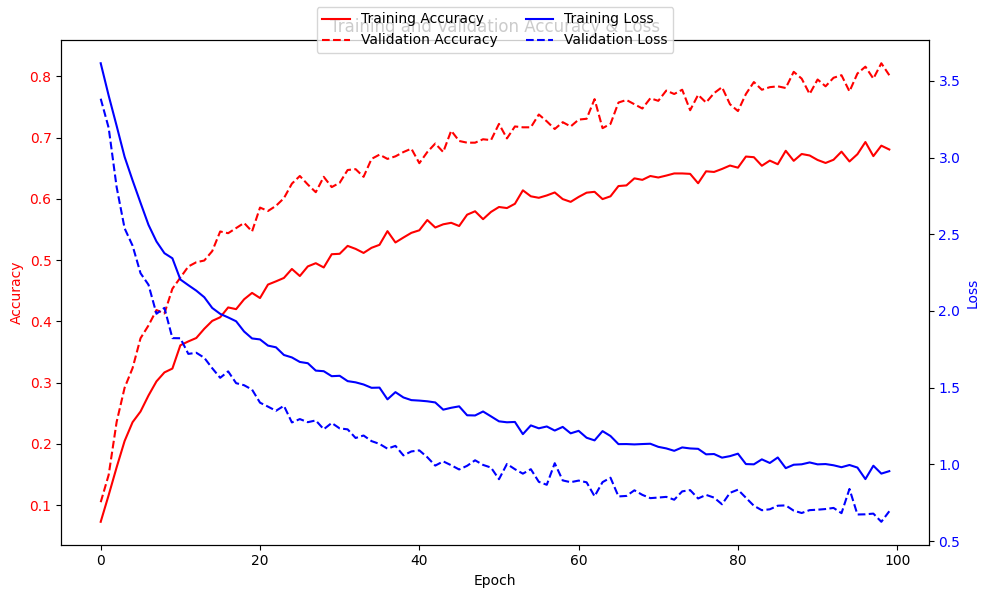

In [23]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy on primary y-axis
ax1.plot(epochs, acc, 'r-', label='Training Accuracy')
ax1.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create a secondary y-axis for loss
ax2 = ax1.twinx()
ax2.plot(epochs, loss, 'b-', label='Training Loss')
ax2.plot(epochs, val_loss, 'b--', label='Validation Loss')
ax2.set_ylabel('Loss', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', ncol=2)

plt.title('Training and Validation Accuracy & Loss')
plt.tight_layout()
plt.show()

Generating predictions on the test set...


c:\Users\calviem\OneDrive - Rose-Hulman Institute of Technology\Desktop\brain_scan_analyzer\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step
Computing confusion matrix...
Confusion matrix saved as confusion_matrix.png


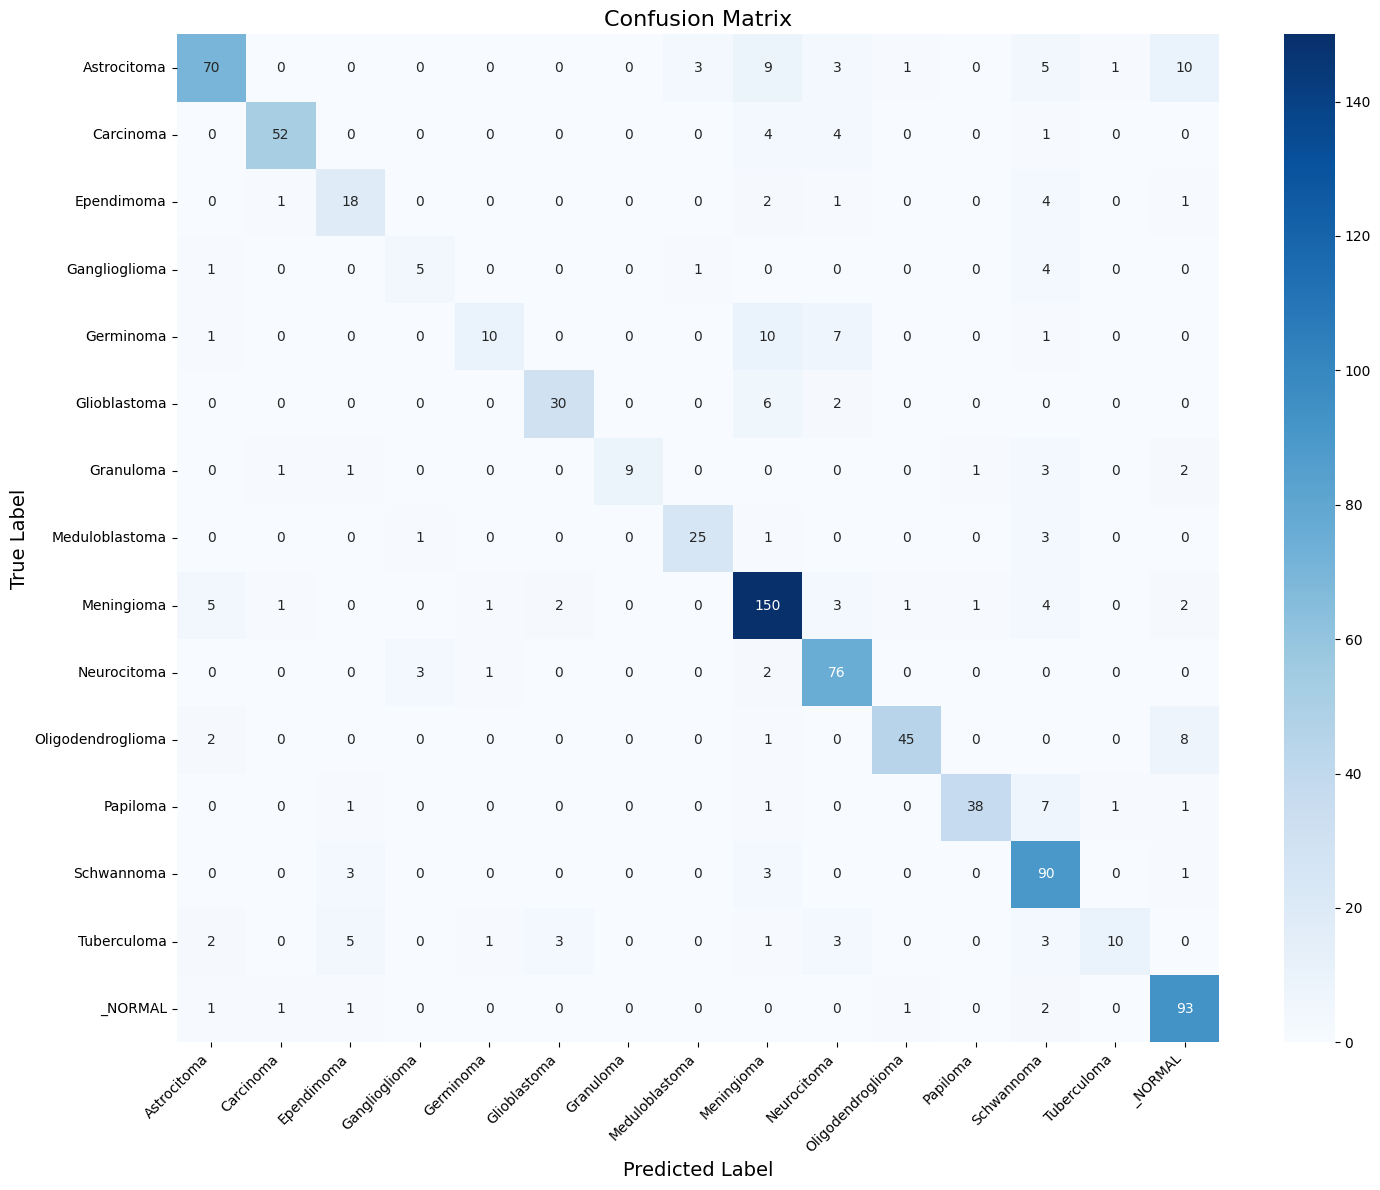

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the best weights saved by ModelCheckpoint
# Evaluation
model = tf.keras.models.load_model('../models/tumor_15.keras', compile=False)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Get predictions on the test set
print("Generating predictions on the test set...")
predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the test generator
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Compute the confusion matrix
print("Computing confusion matrix...")
cm = confusion_matrix(true_classes, predicted_classes)

# Plot and save the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')

print(f"Confusion matrix saved as confusion_matrix.png")